In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__


cuda:0


'0.16.0+cu118'

In [2]:
#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
    num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 72323727.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


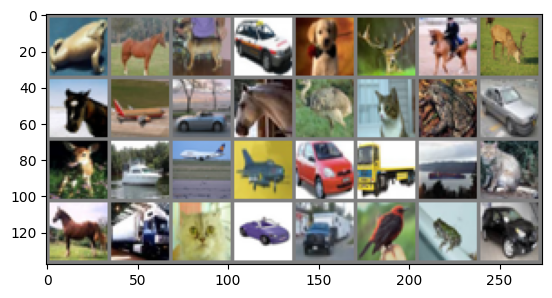

frog  horse dog   car   dog   deer  horse deer  horse plane car   horse bird  cat   frog  car   deer  ship  plane plane car   truck ship  cat   horse truck cat   car   truck bird  frog  car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


net = Net()
net.to(device)


Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
softmax = nn.Softmax(dim=1)

In [19]:
epochs = 100
min_valid_loss = np.inf
train_acc_tracker=[]
valid_acc_tracker=[]

train_loss_tracker=[]
valid_loss_tracker=[]

for e in range(epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader,0):
        # Transfer Data to GPU if available
        net.to(device)
        net.train()
        inputs, labels = data[0].to(device), data[1].to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        outputs = net(inputs)
        # Find the Loss
        loss = criterion(outputs,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data,1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100* (correct_train / total_train)

    valid_loss = 0.0
    correct_val = 0
    total_val = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # Transfer Data to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)
            # Forward Pass
            outputs = net(inputs)
            # Find the Loss
            loss = criterion(outputs,labels)
            # Calculate Loss
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100* (correct_val / total_val)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
    print(f'Epoch {e+1} \t\t Training Acc: {train_accuracy} \t\t Validation Acc: {val_accuracy}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(net.state_dict(), 'saved_model.pth')

    train_acc_tracker.append(train_accuracy)
    valid_acc_tracker.append(val_accuracy)

    train_loss_tracker.append(train_loss / len(trainloader))
    valid_loss_tracker.append(valid_loss / len(validloader))

Epoch 1 		 Training Loss: 2.3025630210876464 		 Validation Loss: 2.3026206622870204
Epoch 1 		 Training Acc: 10.16 		 Validation Acc: 9.879999999999999
Validation Loss Decreased(inf--->720.720267) 	 Saving The Model
Epoch 2 		 Training Loss: 2.3026247797012327 		 Validation Loss: 2.302616095009703
Epoch 2 		 Training Acc: 10.055 		 Validation Acc: 9.879999999999999
Validation Loss Decreased(720.720267--->720.718838) 	 Saving The Model


In [7]:
# acc_tracker=[]
# loss_tracker=[]
# val_acc_tracker=[]
# val_loss_tracker=[]
# total_train = 0

# for epoch in range(10):
#     # Training loop
#     train_loss = 0.0
#     train_acc = 0.0
#     iter_inbatch = 0

#     net.train()
#     for i, data in enumerate(trainloader,0):
#         net.to(device)
#         inputs, labels = data[0].to(device), data[1].to(device)
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         # get probabilites of each label
#         proba = softmax(outputs).cpu().detach().numpy()
#         # get predicted label
#         pred_labels = [np.argmax(i) for i in proba]
#         pred_labels = np.array(pred_labels)

#         # Calculated accuracy
#         correct = 0
#         accuracy = 0

#         # allocate label to cpu
#         gt_labels = labels.cpu().detach().numpy()

#         for p ,g in zip(pred_labels,gt_labels):

#             if p == g:
#                 correct+=1

#         acc = 100 * (correct/len(gt_labels))

#         loss.backward()
#         optimizer.step()

#         train_acc +=acc
#         iter_inbatch +=1
#         train_loss += loss.item()


#         # Validation loop
#         net.eval()
#         valid_loss = 0.0
#         val_acc = 0.0
#         val_iter_inbatch = 0

#         with torch.no_grad():
#             for i,data in enumerate(validloader,0):
#                 inputs, val_labels = data[0].to(device), data[1].to(device)
#                 val_outputs = net(inputs)
#                 loss = criterion(val_outputs, val_labels)
#                 valid_loss += loss.item()

#                 # get probabilites of each label
#                 val_proba = softmax(val_outputs).cpu().detach().numpy()
#                 # get predicted label
#                 val_pred_labels = [np.argmax(i) for i in val_proba]
#                 val_pred_labels = np.array(val_pred_labels)

#                 # Calculated accuracy
#                 val_correct = 0
#                 val_accuracy = 0

#                 # allocate label to cpu
#                 val_gt_labels = val_labels.cpu().detach().numpy()

#                 for val_p ,val_g in zip(val_pred_labels, val_gt_labels):

#                     if val_p == val_g:
#                         val_correct+=1

#                 val_acc = 100 * (val_correct/len(val_gt_labels))

#                 # backprop and optmizer update weight
#                 val_acc +=val_acc
#                 val_iter_inbatch +=1




#     print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
#     print(f'Epoch {epoch+1} \t\t Training acc: {train_acc / len(inter_inbatch)} \t\t Validation acc: {val_acc / len(val_iter_inbatch)}')

#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f\
#         }--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss

#         # Saving State Dict
#         torch.save(net.state_dict(), 'saved_model.pth')


#         # print("Training Epochs : {} , Loss : {} , Acc : {} ".format(epoch,(running_loss/iter_inbatch), (running_acc/iter_inbatch)))

#     # # get loss in current epoch
#     # train_loss = running_loss/iter_inbatch # calculate a mean loss (total loss / iteration)
#     # train_acc = running_acc/iter_inbatch
#     # print(f'Epoch {epoch} Training Loss: {train_loss} Accuracy: {train_acc}')
#     # val_train_loss = val_running_loss/val_iter_inbatch
#     # val_train_acc = val_running_acc/val_iter_inbatch
#     # print(f'Epoch {epoch} Val Loss: {val_train_loss} Val Accuracy: {val_train_acc}')

#     # loss_tracker.append(train_loss)
#     # acc_tracker.append(train_acc)

#     # val_loss_tracker.append(val_train_loss)
#     # val_acc_tracker.append(val_train_acc)

In [8]:
# acc_tracker=[]
# loss_tracker=[]
# val_acc_tracker=[]
# val_loss_tracker=[]
# total_train = 0

# for epoch in range(100):  # loop over the dataset multiple times

#     running_loss = 0.0
#     running_acc = 0.0
#     iter_inbatch = 0  # Iteration in batch
#     val_running_loss = 0.0
#     val_running_acc = 0.0
#     val_iter_inbatch = 0  # Iteration in batch

#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         net.to(device)
#         net.train()
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)

#         # calcuate an objective loss
#         loss = criterion(outputs, labels)

#         # get probabilites of each label
#         proba = softmax(outputs).cpu().detach().numpy()
#         # get predicted label
#         pred_labels = [np.argmax(i) for i in proba]
#         pred_labels = np.array(pred_labels)


#         # Calculated accuracy
#         correct = 0
#         accuracy = 0

#         # allocate label to cpu
#         gt_labels = labels.cpu().detach().numpy()

#         for p ,g in zip(pred_labels,gt_labels):

#             if p == g:
#                 correct+=1

#         acc = 100 * (correct/len(gt_labels))

#         # backprop and optmizer update weight
#         loss.backward()
#         optimizer.step()
#         running_acc +=acc
#         running_loss +=loss.item()
#         iter_inbatch +=1


#     for i, val_data in enumerate(validloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         net.to(device)
#         net.eval()
#         val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)

#         # forward + backward + optimize
#         val_outputs = net(val_inputs)

#         # calcuate an objective loss
#         val_loss = criterion(val_outputs, val_labels)

#         # get probabilites of each label
#         val_proba = softmax(val_outputs).cpu().detach().numpy()
#         # get predicted label
#         val_pred_labels = [np.argmax(i) for i in val_proba]
#         val_pred_labels = np.array(val_pred_labels)


#         # Calculated accuracy
#         val_correct = 0
#         val_accuracy = 0

#         # allocate label to cpu
#         val_gt_labels = val_labels.cpu().detach().numpy()

#         for val_p ,val_g in zip(val_pred_labels, val_gt_labels):

#             if val_p == val_g:
#                 val_correct+=1

#         val_acc = 100 * (val_correct/len(val_gt_labels))

#         # backprop and optmizer update weight
#         val_running_acc +=val_acc
#         val_running_loss +=val_loss.item()
#         val_iter_inbatch +=1


#         # print("Training Epochs : {} , Loss : {} , Acc : {} ".format(epoch,(running_loss/iter_inbatch), (running_acc/iter_inbatch)))

#     # get loss in current epoch
#     train_loss = running_loss/iter_inbatch # calculate a mean loss (total loss / iteration)
#     train_acc = running_acc/iter_inbatch
#     print(f'Epoch {epoch} Training Loss: {train_loss} Accuracy: {train_acc}')
#     val_train_loss = val_running_loss/val_iter_inbatch
#     val_train_acc = val_running_acc/val_iter_inbatch
#     print(f'Epoch {epoch} Val Loss: {val_train_loss} Val Accuracy: {val_train_acc}')

#     loss_tracker.append(train_loss)
#     acc_tracker.append(train_acc)

#     val_loss_tracker.append(val_train_loss)
#     val_acc_tracker.append(val_train_acc)

In [7]:
PATH = './val_32_batch_SGD_net.pth'
torch.save(net.state_dict(), PATH)

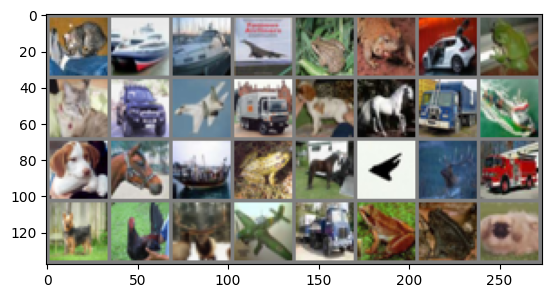

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))
# outputs = net(images)

<All keys matched successfully>

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  deer  deer  deer 


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.7 %
Accuracy for class: car   is 13.8 %
Accuracy for class: bird  is 19.0 %
Accuracy for class: cat   is 1.3 %
Accuracy for class: deer  is 43.7 %
Accuracy for class: dog   is 7.8 %
Accuracy for class: frog  is 13.2 %
Accuracy for class: horse is 2.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.6 %


In [13]:
import csv

csv_filename = "SDG_training_log.csv"
epochlist= [i for i in range(1, e+1) ]
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["nepochs", "accuracy", "loss"])
    csv_writer.writerows(zip(epochlist, train_acc_tracker, train_loss_tracker))

print(f"Logbook exported to {csv_filename}")

Logbook exported to SDG_training_log.csv


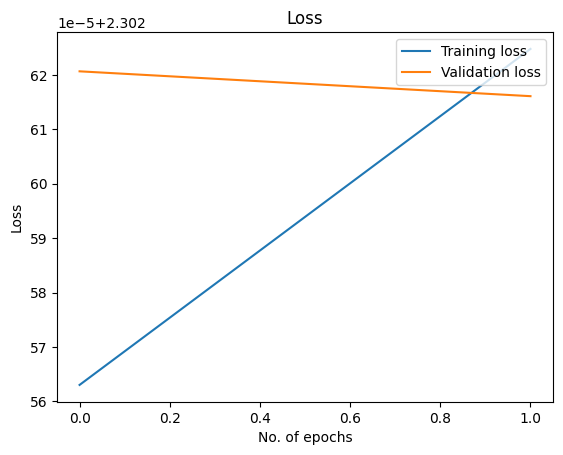

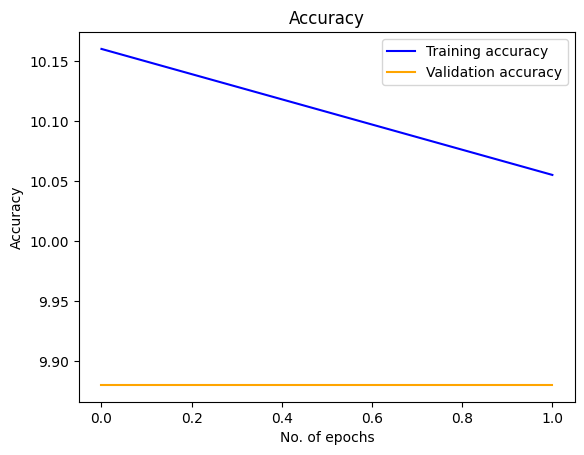

In [22]:
plt.plot(np.arange(0,100), train_loss_tracker, label='Training loss')
plt.plot(np.arange(0,100), valid_loss_tracker, label='Validation loss')
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(train_acc_tracker, label='Training accuracy', color='blue')
plt.plot(valid_acc_tracker, label='Validation accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()